In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir

In [3]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(16, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [13]:
repository = "./test_data/"
obsid_range = [200, 224, 3]
band_name = "g"

In [5]:
imp.load_source('dcr_template', './python/dcr_template.py')
from dcr_template import DcrCorrection
from dcr_template import DcrModel

In [15]:
self = DcrCorrection(n_step=3, repository=repository, obsid_range=obsid_range, band_name=band_name,
                     use_psf=True,use_fft=False, debug_mode=True, kernel_size=7)

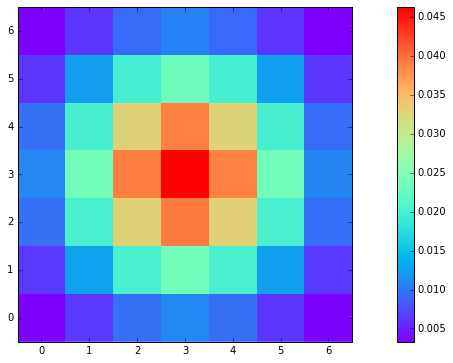

(0.046239038440636662, 0.82451939847547451)


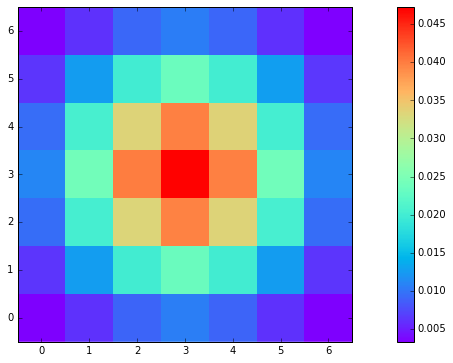

(0.047250595848501852, 0.83083952542468531)


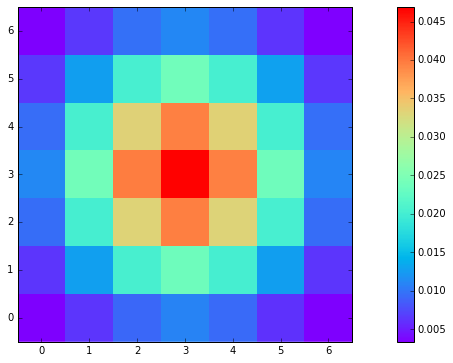

(0.046887449615636831, 0.8346527710566225)
SUM


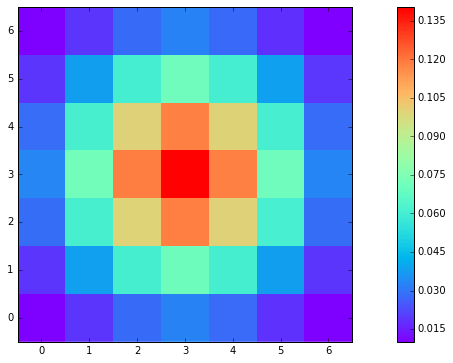

0.140377083905
DIFF


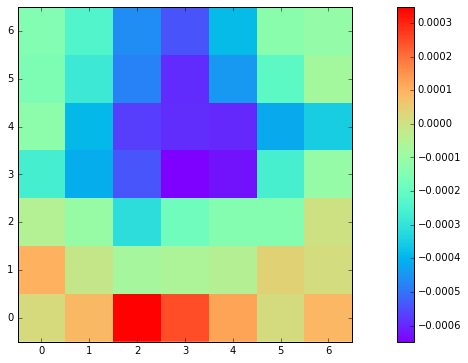

In [16]:
for _i in range(self.n_step):
    look(self.psf_model[_i, :, :])
    print(np.max(self.psf_model[_i, :, :]), np.sum(self.psf_model[_i, :, :]))
print("SUM")
look(np.sum(self.psf_model,axis=0))
print(np.max(np.sum(self.psf_model,axis=0)))
print("DIFF")
look(self.psf_model[0, :, :] - self.psf_model[-1, :, :])

In [17]:
self.build_model(use_full=False, use_regularization=True, use_only_detected=True)

Working on column
 0.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 100.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 200.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 300.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 400.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 500.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 600.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 700.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 800.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
 900.........|.........|.........|.........|....

In [18]:
self.export_model(model_repository="/Users/sullivan/LSST/simulations/test6/output_data_test")

In [19]:
self2=DcrModel(model_repository="/Users/sullivan/LSST/simulations/test6/output_data_test")

Running DcrModel init!


UnboundLocalError: local variable 'dcrModel' referenced before assignment

In [21]:
butler_model = daf_persistence.Butler("/Users/sullivan/LSST/simulations/test6/output_data_test/")

In [30]:
butler_model.getKeys(datasetType='dcrModel')

{'filter': str, 'patch': str, 'subfilter': str, 'tract': int}

In [22]:
butler_model.queryMetadata("dcrModel", "subfilter",dataId={'filter': 'g', 'tract': 0, 'patch': 0})

[]

In [23]:
butler_sub = butler_model.subset("dcrModel")

In [24]:
butler_sub.butler.queryMetadata("dcrModel", "subfilter",dataId={'filter': 'g', 'tract': 0, 'patch': 0})

[]

In [26]:
model = butler_model.get("dcrModel", dataId={'filter': 'g', 'tract': 0, 'patch': 0, "subfilter":0})

In [27]:
model_img = model.getMaskedImage().getImage().getArray()

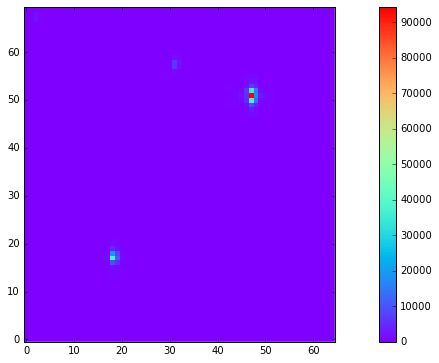

In [29]:
x0 = 150
dx = 65
y0 = 480
dy = 70
look(model_img,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])

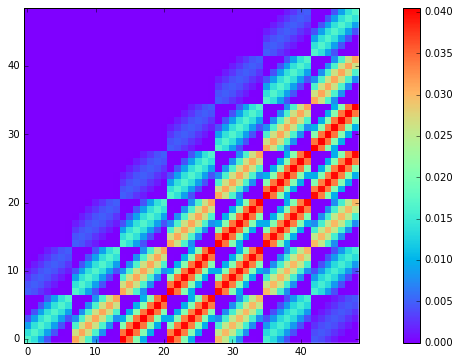

In [31]:
look(self.dcr_kernel[0:self.kernel_size**2,0:self.kernel_size**2])

In [19]:
x0 = 150
dx = 65
y0 = 480
dy = 70

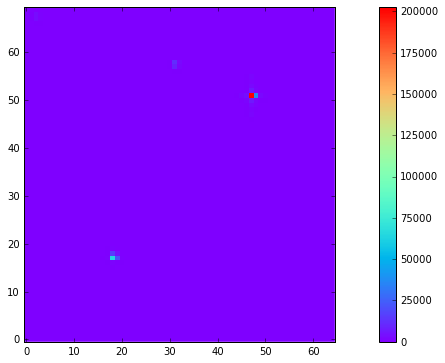

('max: ', 202544.04472372591, 'sum: ', 482990.49022501102)


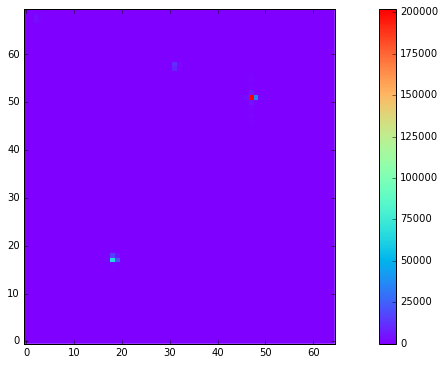

('max: ', 201889.3014448717, 'sum: ', 483046.23442866618)


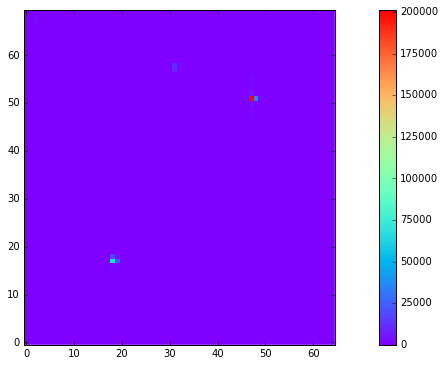

('max: ', 201214.63840588971, 'sum: ', 485969.11203950405)
SUM


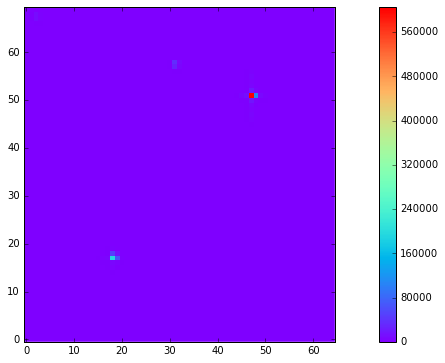

DIFF


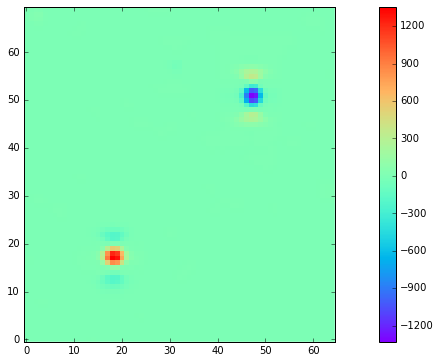

In [912]:
for _i in range(self.n_step):
    look(self.view_model(_i),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
    print("max: ", np.max(self.view_model(_i)), "sum: ", np.sum(self.view_model(_i)))
print("SUM")
look(np.sum([self.view_model(_i) for _i in range(self.n_step)],axis=0),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])

print("DIFF")
look(self.view_model(-1) - self.view_model(0),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy],range=[-1e4,1e4])

In [914]:
# output_directory='/Users/sullivan/LSST/simulations/test6/dcr_with_psf/'
template_exposure_gen = self.generate_templates_from_model(obsid_range=[208,211],use_full=False,output_directory='temp')
im_arr = []
for exp in template_exposure_gen:
    im_arr.append(exp.getMaskedImage().getImage().getArray())

In [9]:
calexp_208 = self.butler.get("calexp", dataId={'visit': 208, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_209 = self.butler.get("calexp", dataId={'visit': 209, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_210 = self.butler.get("calexp", dataId={'visit': 210, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})

NameError: name 'self' is not defined

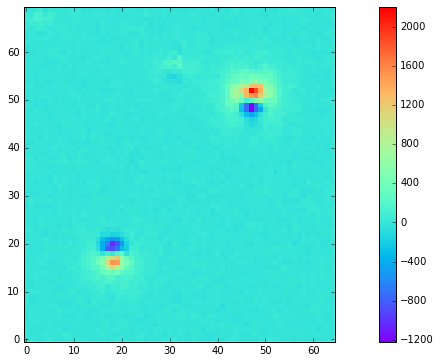

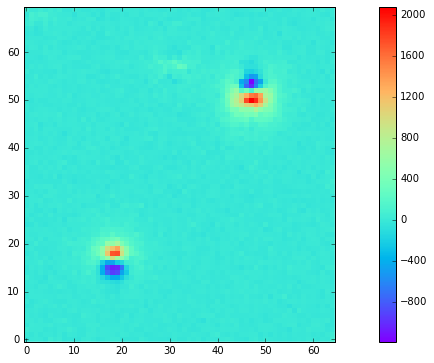

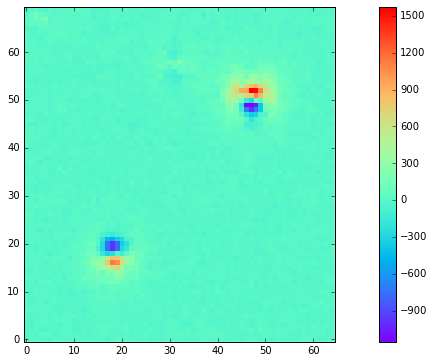

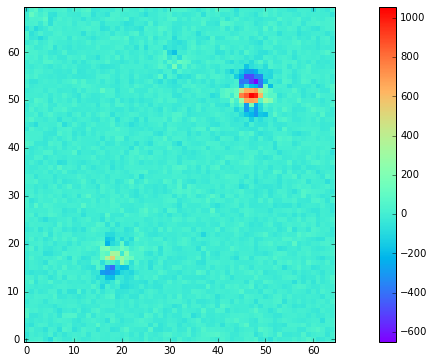

In [871]:
look(calexp_208.getMaskedImage().getImage().getArray() - im_arr[0],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_209.getMaskedImage().getImage().getArray() - im_arr[1],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_210.getMaskedImage().getImage().getArray() - im_arr[2],x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
look(calexp_210.getMaskedImage().getImage().getArray() - calexp_208.getMaskedImage().getImage().getArray(),
     x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])

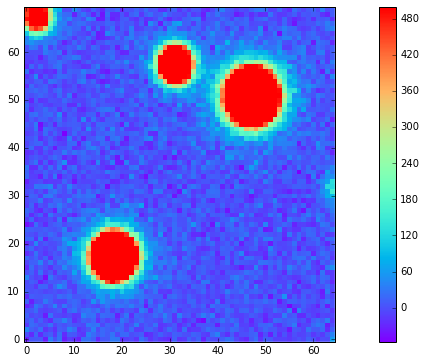

In [810]:
look(calexp_209.getMaskedImage().getImage().getArray(),range=[-5e2,5e2],x_range=[150, 215],y_range=[480,550])

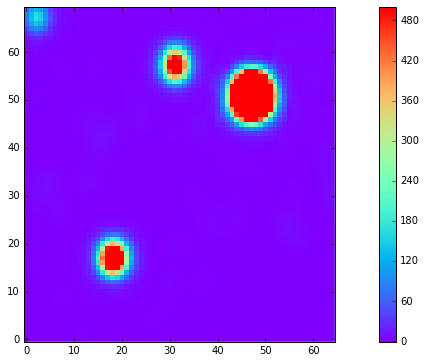

In [850]:
look(im_arr[2],range=[-5e2,5e2],x_range=[150, 215],y_range=[480,550])

In [558]:
psf_test = self.exposures[0].getPsf()
psf_test.computeApertureFlux(1)

0.09093171818927051

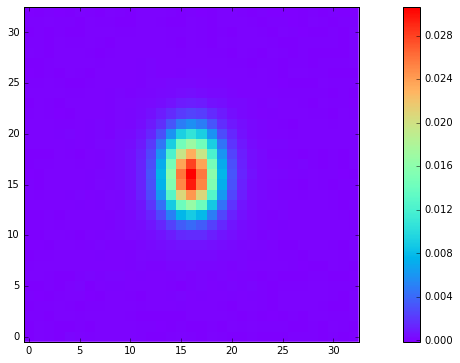

In [563]:
look(psf_test.computeKernelImage().getArray())

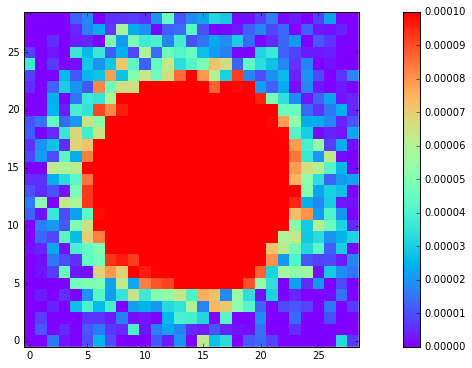

In [874]:
look(exp.getPsf().computeKernelImage().getArray(),range=[0,0.0001])

In [877]:
self.photoParams.effarea

331830.724

In [885]:
def test_fn(**kwargs):
    for item in kwargs:
        print(item, kwargs[item])

In [887]:
test_fn()

In [915]:
self.butler.queryMetadata?

In [921]:
dataId = {'visit':None,'raft': '2,2', 'sensor': '1,1', 'filter': 'g'}
self.butler.queryMetadata("calexp","visit", dataId=dataId)

[]

In [923]:
meta = self.exposures[0].getMetadata()

In [924]:
meta.get("AIRMASS")

2.0